# Imports

In [3]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

False
0


RuntimeError: No CUDA GPUs are available

In [3]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler, create_dataloaders
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, export_dynamic_orbits_html, plot_combined_latent_space_2d, plot_latent_space_with_feature_distributions
from orbit_generation.stats import plot_histograms_comparison, reduce_dimensions_plot_latent_space, reduce_dimensions_plot_combined_latent_space
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.architectures import VAELossHistory
from orbit_generation.propagation import calculate_errors
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics
from orbit_generation.evaluation import evaluate_clustering_multiple_labels, calculate_closest_feature_distances

In [4]:
import numpy as np
import os
from pytorch_lightning import Trainer

# Parameters

In [5]:
want_to_train = False                        # Set this parameter to False if you want to load the model from the folder
want_to_generate = False                     # Set this parameter to False if you want to load the generation from the folder
calculate_error_metrics = False                    # Set this parameter to False if you don't want to calculate any metric
want_to_generate_latent_space = True        # Set this parameter to False if you don't wan't to generate the latent space
want_to_get_cluster_metrics = True          # Set this parameter to False if you want to load the generation from the folder
want_to_study_converged_orbits = True       # Set this parameter to False if you don't want to calculate any metric

In [6]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [7]:
params = {
    'model_name': 'vae_conv5_legit',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 2,
    'feature_dim': 7,
    'seq_len': 100,
    'val_split': 0.05,
    'batch_size': 32,
    'epochs': 25,
    'beta': 2,
    'lr': 0.001,
    'dropout_rate': 0.2
}

# Data

## Import

In [8]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 100)

Remove the time variable if specified in params

In [9]:
if params['feature_dim']==6:
    data=data[:,1:,:]
    data.shape

## Scaling

In [10]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([45211, 7, 100])

# Modelling

In [11]:
model = get_model(params)

In [12]:
train_loader, val_loader = create_dataloaders(scaled_data, val_split=params.get('val_split', 0.1), batch_size=params.get('batch_size', 32))

In [13]:
loss_history = VAELossHistory()

trainer = Trainer(
    max_epochs=params.get('epochs', 10),
    log_every_n_steps=10,
    devices="auto",
    accelerator="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    callbacks=[loss_history]
)

trainer.fit(model, train_loader, val_loader)

for metric_name, metric_value in trainer.callback_metrics.items():
    print(f"{metric_name}: {metric_value}")

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


val_total_loss: 14.014758110046387
val_reconstruction_loss: 9.938416481018066
val_kl_loss: 4.0763444900512695
train_total_loss: 14.201065063476562
train_reconstruction_loss: 10.017423629760742
train_kl_loss: 4.183642387390137


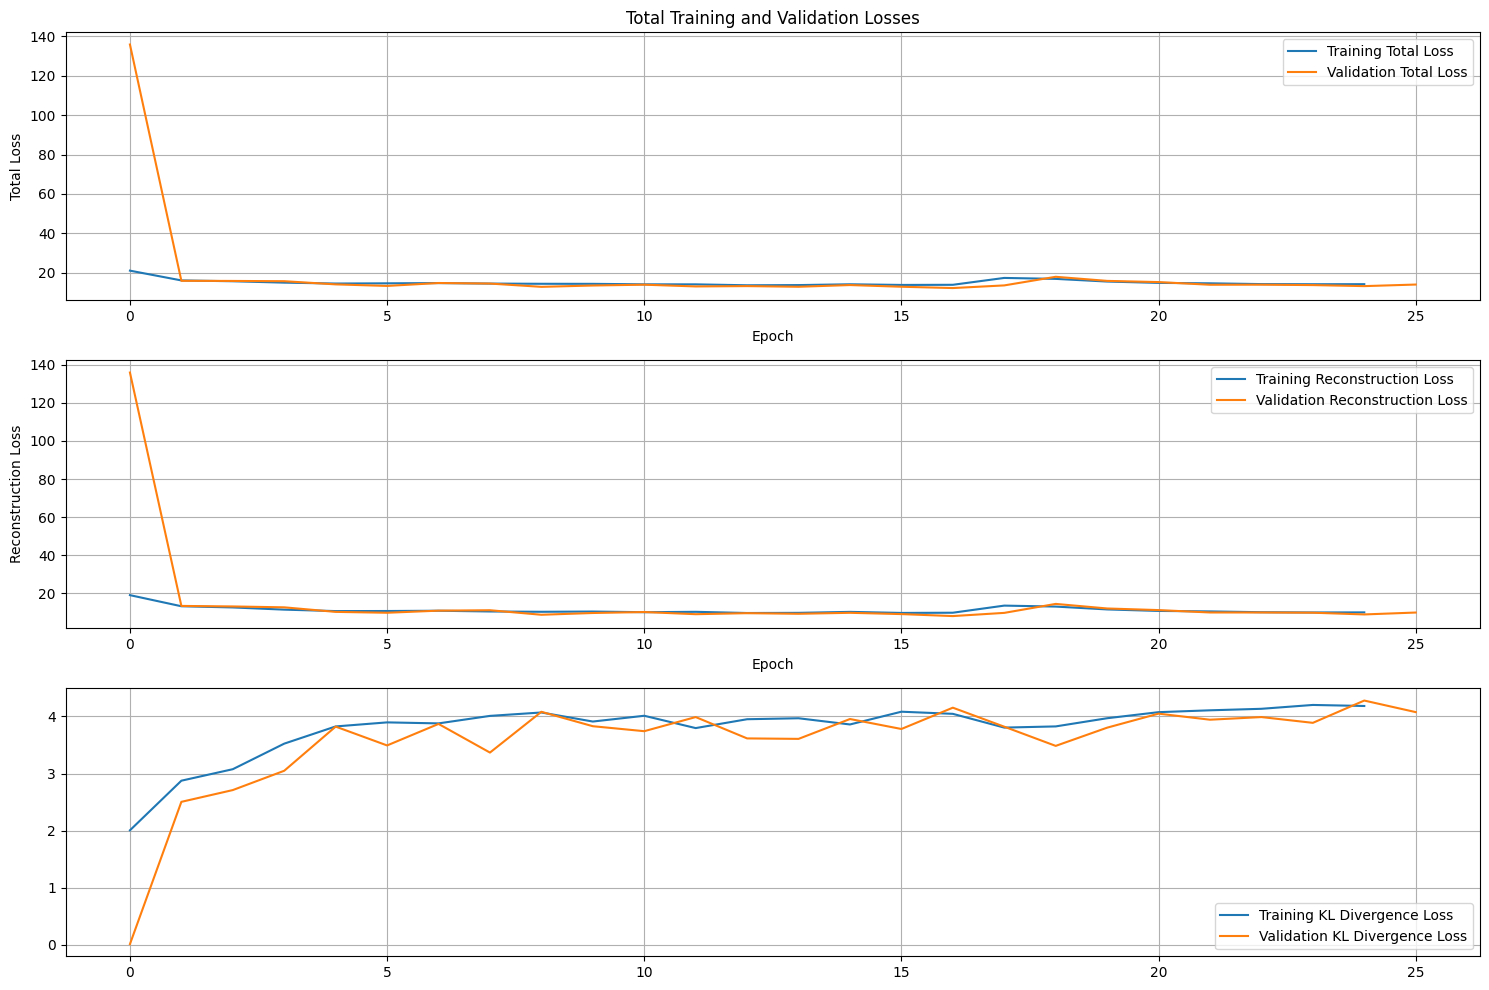

In [14]:
loss_history.plot_all_losses()

## Saving

In [15]:
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

New experiment setup complete: ../experiments/experiment_7
Parameters saved to ../experiments/experiments.json.


Define full paths for saving

In [16]:
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_all_generated_orbits.png')
static_some_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_some_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
converged_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_converged_orbits')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')

In [17]:
if want_to_train:
    add_experiment_metrics(experiments_folder, params=params, metrics=trainer.callback_metrics)
    

Metrics added to experiment with ID 7 in ../experiments/experiments.json.


In [18]:
torch.save(model.state_dict(), model_save_path)

## Generate

In [19]:
if want_to_generate:
    # Generate the orbits
    num_samples=100
    generation = model.sample(num_samples)
    generation = scaler.inverse_transform(generation)
    np.save(generated_data_path, generation.detach().numpy())
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

torch.Size([100, 7, 100])

# Analysis of Generation

## Visualization

In [20]:
if generation.shape[1] == 7:
    no_time_generation = generation[:,1:,:].detach().numpy()
    generation.shape
else:
    no_time_generation = generation.cpu().numpy()

no_time_generation.shape

(100, 6, 100)

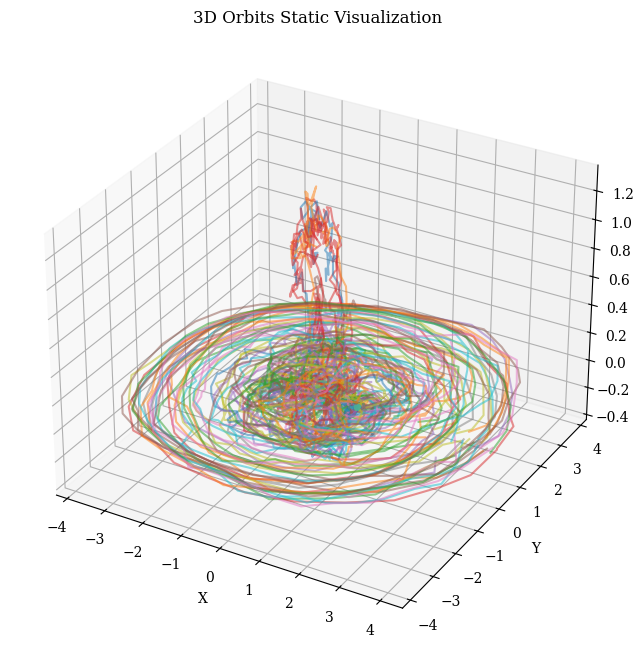

In [21]:
visualize_static_orbits(data= no_time_generation, show_legend=False, save_path=static_all_orbit_path)

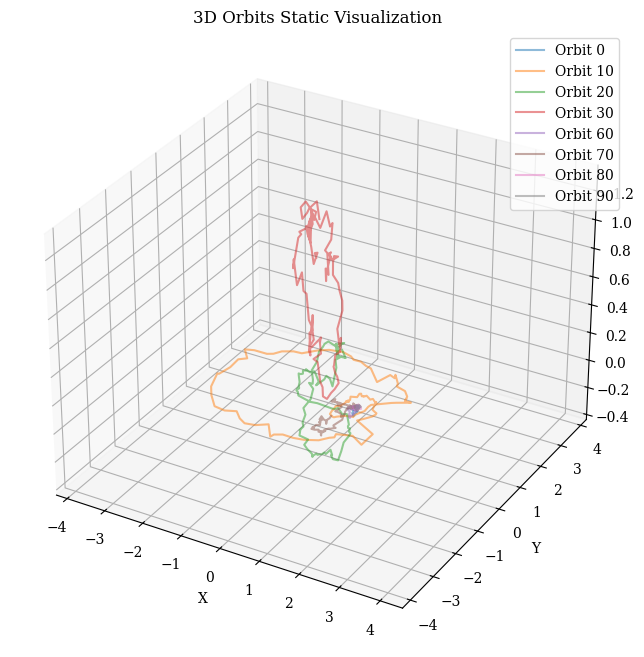

In [22]:
visualize_static_orbits(data= no_time_generation, orbit_indices=[0,10,20,30,60,70,80,90], save_path=static_some_orbit_path)

In [23]:
export_dynamic_orbits_html(data=no_time_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_7/images/exp7_generated_orbits.html


## Coverage

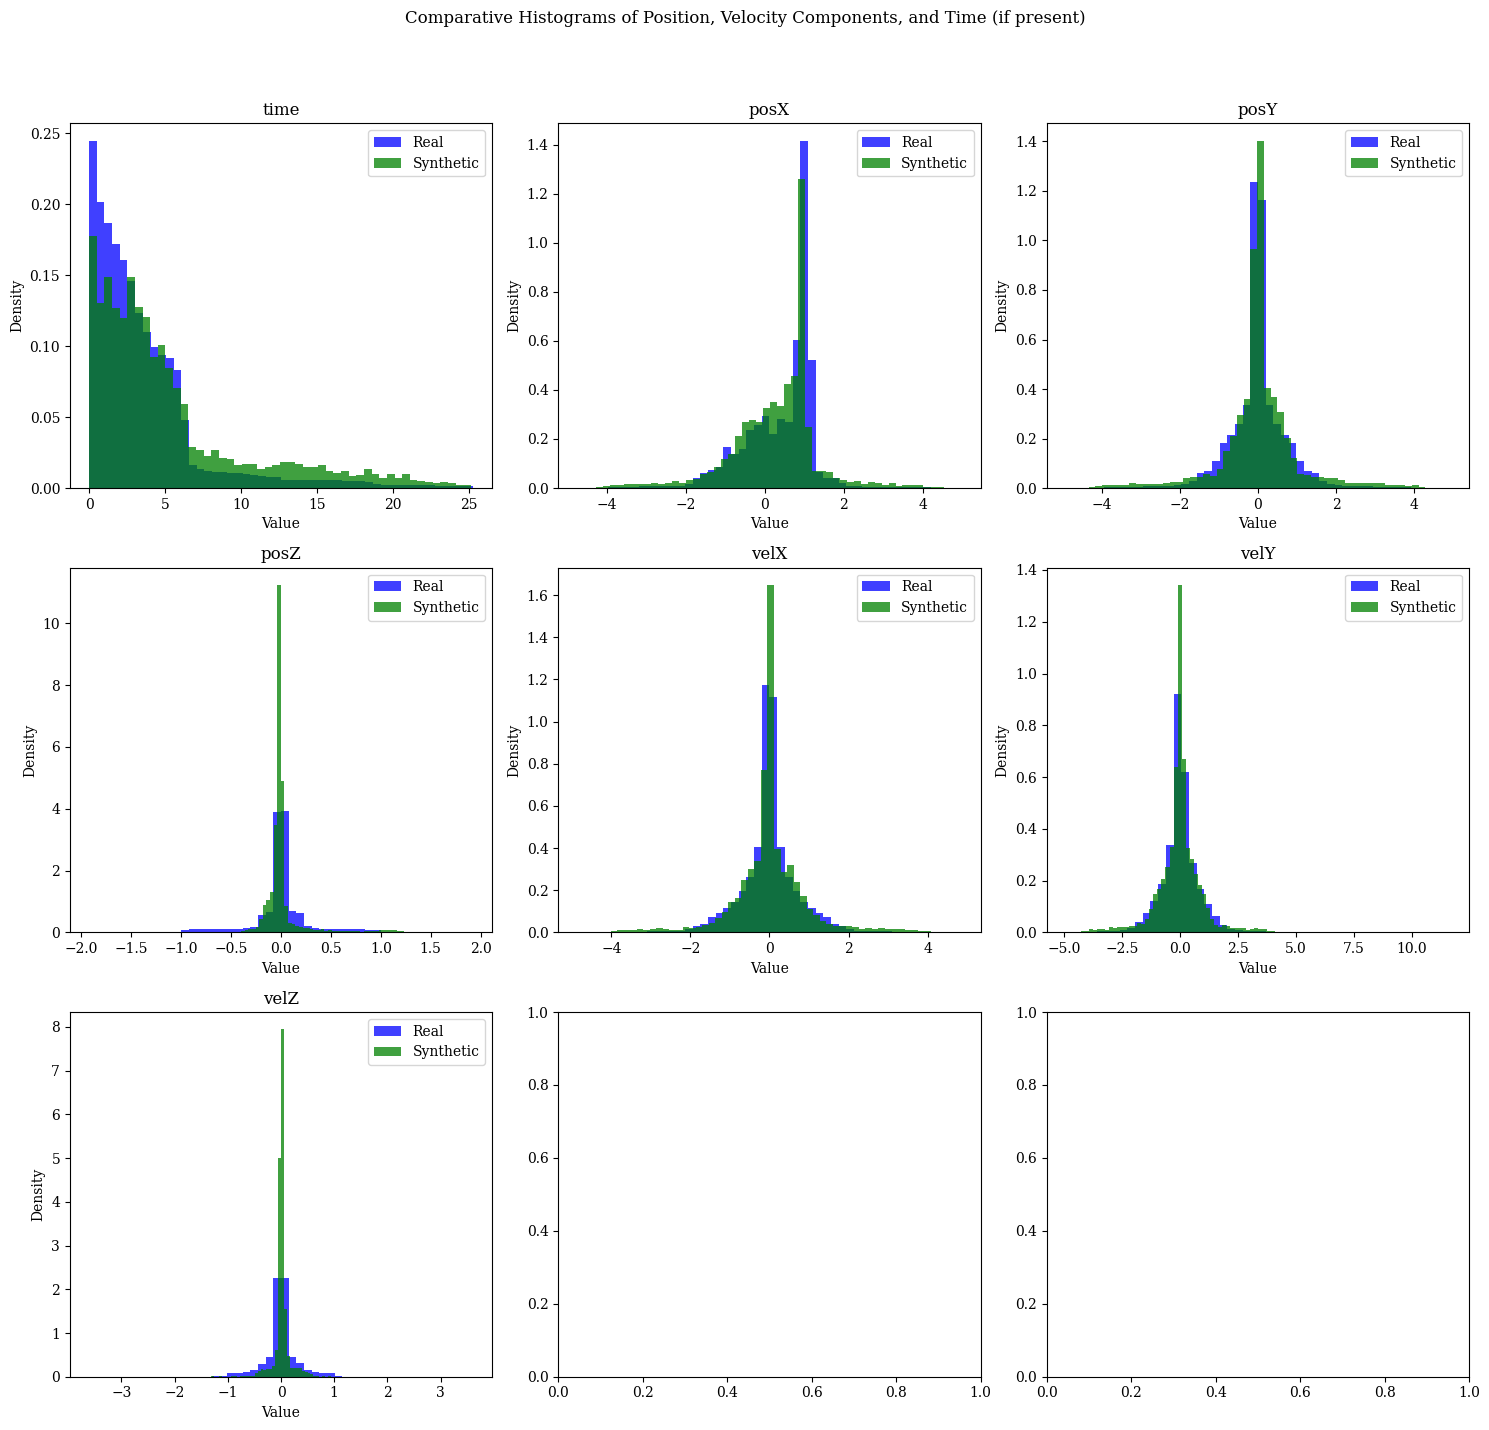

In [24]:
plot_histograms_comparison(data1=data, data2=generation.detach().numpy(), label1='Real', label2='Synthetic', normalize=True)

## Pheasibility

Cumulative position error for selected orbits: 3630.468707795382
Average position error per time step: 36.671401088842245


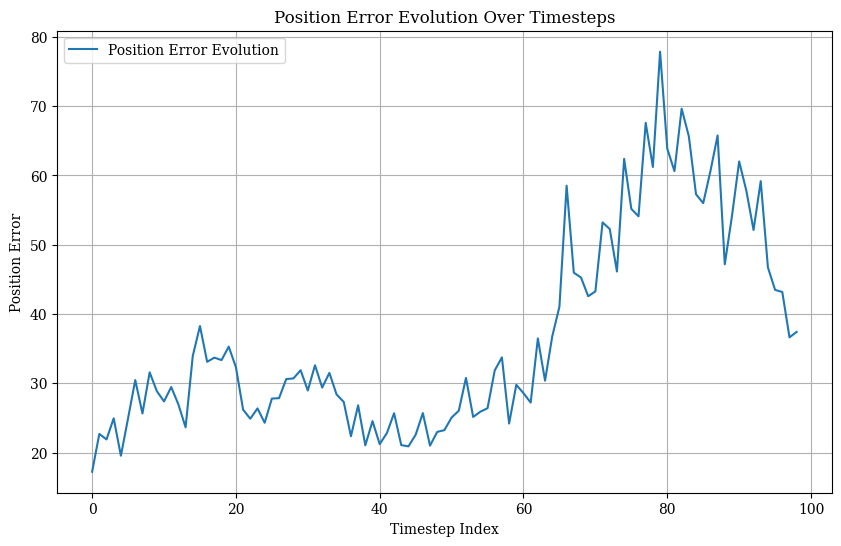

Cumulative velocity error for selected orbits: 5220.8031060738385
Average velocity error per time step: 52.73538490983675


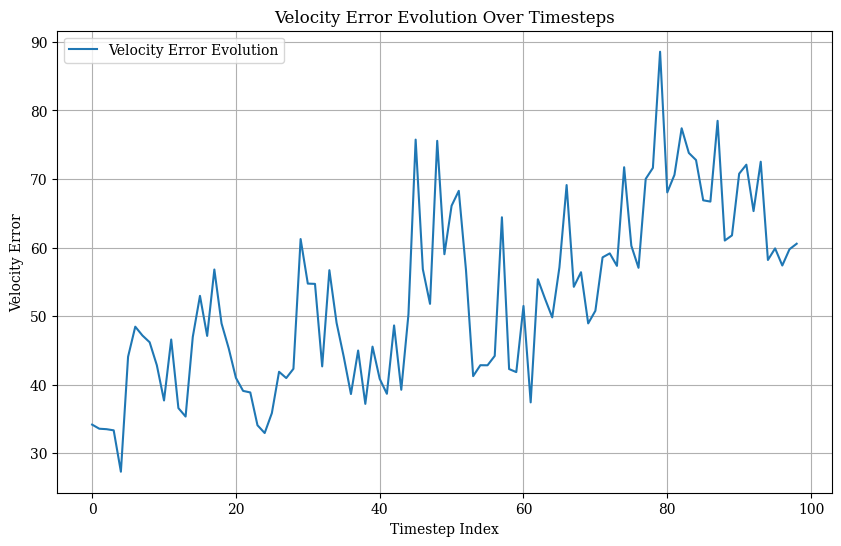

Cumulative energy error for selected orbits: 9972.5390625
Average energy error per time step: 100.73271942138672


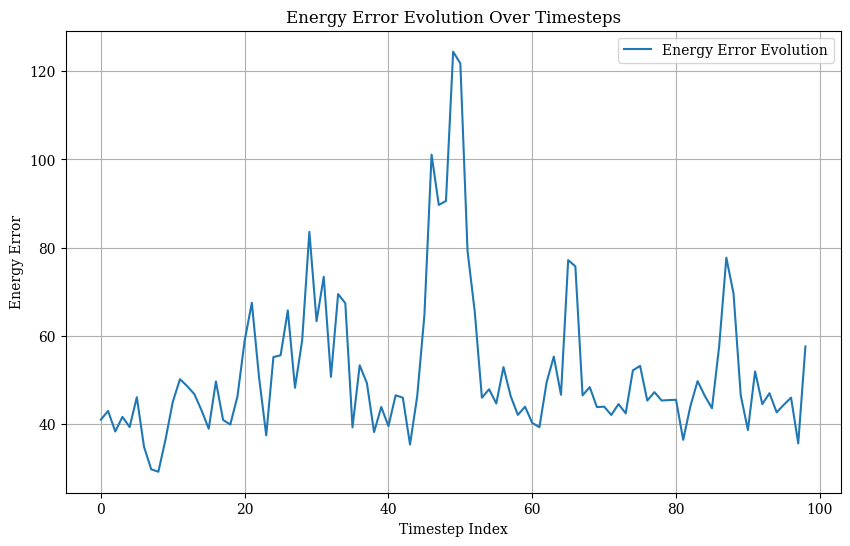

Metrics added to experiment with ID 7 in ../experiments/experiments.json.


In [25]:
if calculate_error_metrics:
    reordered_orbits, order_metrics = reorder_orbits(generation.detach().numpy())
    errors = calculate_errors(reordered_orbits,EM_MU)
    add_experiment_metrics(experiments_folder, params=params, metrics={**errors, **order_metrics})

# Latent Space

In [28]:
latent_mean, latent_log_var = model.encode(scaled_data)
latent_mean = latent_mean.detach().numpy()
latent_representation = np.concatenate((latent_mean, latent_log_var.detach().numpy()), axis=1)
np.save(latent_representations_path, latent_representation)
latent_representation.shape

(45211, 4)

In [43]:
orbits_id_classes = [orbit_df.at[index, 'id_class'] for index in labels]
family_labels=get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

## Visualize

In [45]:
latent_mean.shape

(45211, 2)

In [47]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.cm as cm
from matplotlib import colormaps
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from typing import Optional, List, Dict, Any, Union

#| export
def plot_latent_space_with_feature_distributions(latent_representations: np.ndarray,
                                                 labels: np.ndarray,
                                                 features: Optional[np.ndarray] = None,
                                                 feature_names: Optional[list] = None,
                                                 figsize: tuple = (12, 12),  # Adjusted to be a square
                                                 save_path: Optional[str] = None,
                                                 many_classes: bool = False,
                                                 show_legend: bool = True,
                                                 legend_fontsize: int = 8,
                                                 **kwargs: Any) -> None:
    """
    Plots the latent space with class colors and normalized vertical and horizontal feature distributions in separate subplots.
    """
    # Encode string labels to integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    class_names = label_encoder.classes_

    # Use a colormap for better color differentiation
    cmap = plt.get_cmap('tab20')  # You can change 'tab20' to any other colormap
    markers = ['o', 's', '^', 'v', 'D', '<', '>', 'p', '*', 'h', 'H', '8']  # Marker styles

    # Create subplots
    fig = plt.figure(figsize=figsize)
    # Adjust height_ratios and width_ratios to ensure square latent space plot
    gs = fig.add_gridspec(2, 2, height_ratios=[5, 1], width_ratios=[5, 1])

    ax1 = fig.add_subplot(gs[0, 0])  # Latent space plot
    ax2 = fig.add_subplot(gs[1, 0])  # Horizontal distribution plot
    ax3 = fig.add_subplot(gs[0, 1], sharey=ax1)  # Vertical distribution plot

    # Plot the latent representations with class colors
    if many_classes:
        for class_idx, class_name in enumerate(class_names):
            class_mask = (encoded_labels == class_idx)
            color = cmap(class_idx / len(class_names))
            marker = markers[class_idx % len(markers)]
            ax1.scatter(latent_representations[class_mask, 0], latent_representations[class_mask, 1],
                        label=class_name, marker=marker, color=color, s=30, **kwargs)
    else:
        unique_labels = np.unique(encoded_labels)
        for class_idx, class_name in zip(unique_labels, class_names):
            class_mask = (encoded_labels == class_idx)
            color = cmap(class_idx / len(class_names))
            ax1.scatter(latent_representations[class_mask, 0], latent_representations[class_mask, 1],
                        label=class_name, color=color, s=30, **kwargs)

    ax1.set_title('2D Latent Space Visualization')
    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2')
    ax1.set_aspect('equal', 'box')  # Ensure the latent space plot is square
    if show_legend:
        ax1.legend(title="Classes", fontsize=legend_fontsize)

    if features is not None and feature_names is not None:
        # Horizontal distribution
        x_min, x_max = np.min(latent_representations[:, 0]), np.max(latent_representations[:, 0])
        x_bins = np.linspace(x_min, x_max, 100)

        for feature_index, feature_name in enumerate(feature_names):
            feature_values = features[:, feature_index]
            avg_feature_values = []

            for i in range(len(x_bins) - 1):
                mask = (latent_representations[:, 0] >= x_bins[i]) & (latent_representations[:, 0] < x_bins[i+1])
                avg_feature_values.append(np.mean(feature_values[mask]) if np.sum(mask) > 0 else 0)

            avg_feature_values = np.array(avg_feature_values)
            # Normalize the feature values
            avg_feature_values = (avg_feature_values - np.min(avg_feature_values)) / (np.max(avg_feature_values) - np.min(avg_feature_values) + 1e-8)
            # Plot the normalized distributions
            ax2.plot((x_bins[:-1] + x_bins[1:]) / 2, avg_feature_values, label=f'{feature_name} distribution')

        ax2.set_title('Normalized Horizontal Feature Distributions')
        ax2.set_xlabel('Dimension 1')
        ax2.set_ylabel('Normalized Feature Value')
        if show_legend:
            ax2.legend(fontsize=legend_fontsize)

        # Vertical distribution
        y_min, y_max = np.min(latent_representations[:, 1]), np.max(latent_representations[:, 1])
        y_bins = np.linspace(y_min, y_max, 100)

        for feature_index, feature_name in enumerate(feature_names):
            feature_values = features[:, feature_index]
            avg_feature_values = []

            for i in range(len(y_bins) - 1):
                mask = (latent_representations[:, 1] >= y_bins[i]) & (latent_representations[:, 1] < y_bins[i+1])
                avg_feature_values.append(np.mean(feature_values[mask]) if np.sum(mask) > 0 else 0)

            avg_feature_values = np.array(avg_feature_values)
            # Normalize the feature values
            avg_feature_values = (avg_feature_values - np.min(avg_feature_values)) / (np.max(avg_feature_values) - np.min(avg_feature_values) + 1e-8)
            # Plot the normalized distributions
            ax3.plot(avg_feature_values, (y_bins[:-1] + y_bins[1:]) / 2, label=f'{feature_name} distribution')

        ax3.set_title('Normalized Vertical Feature Distributions')
        ax3.set_xlabel('Normalized Feature Value')
        ax3.set_ylabel('Dimension 2')
        if show_legend:
            ax3.legend(fontsize=legend_fontsize)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    plt.show()

Saved plot to ../experiments/experiment_7/images/exp7_latent_space


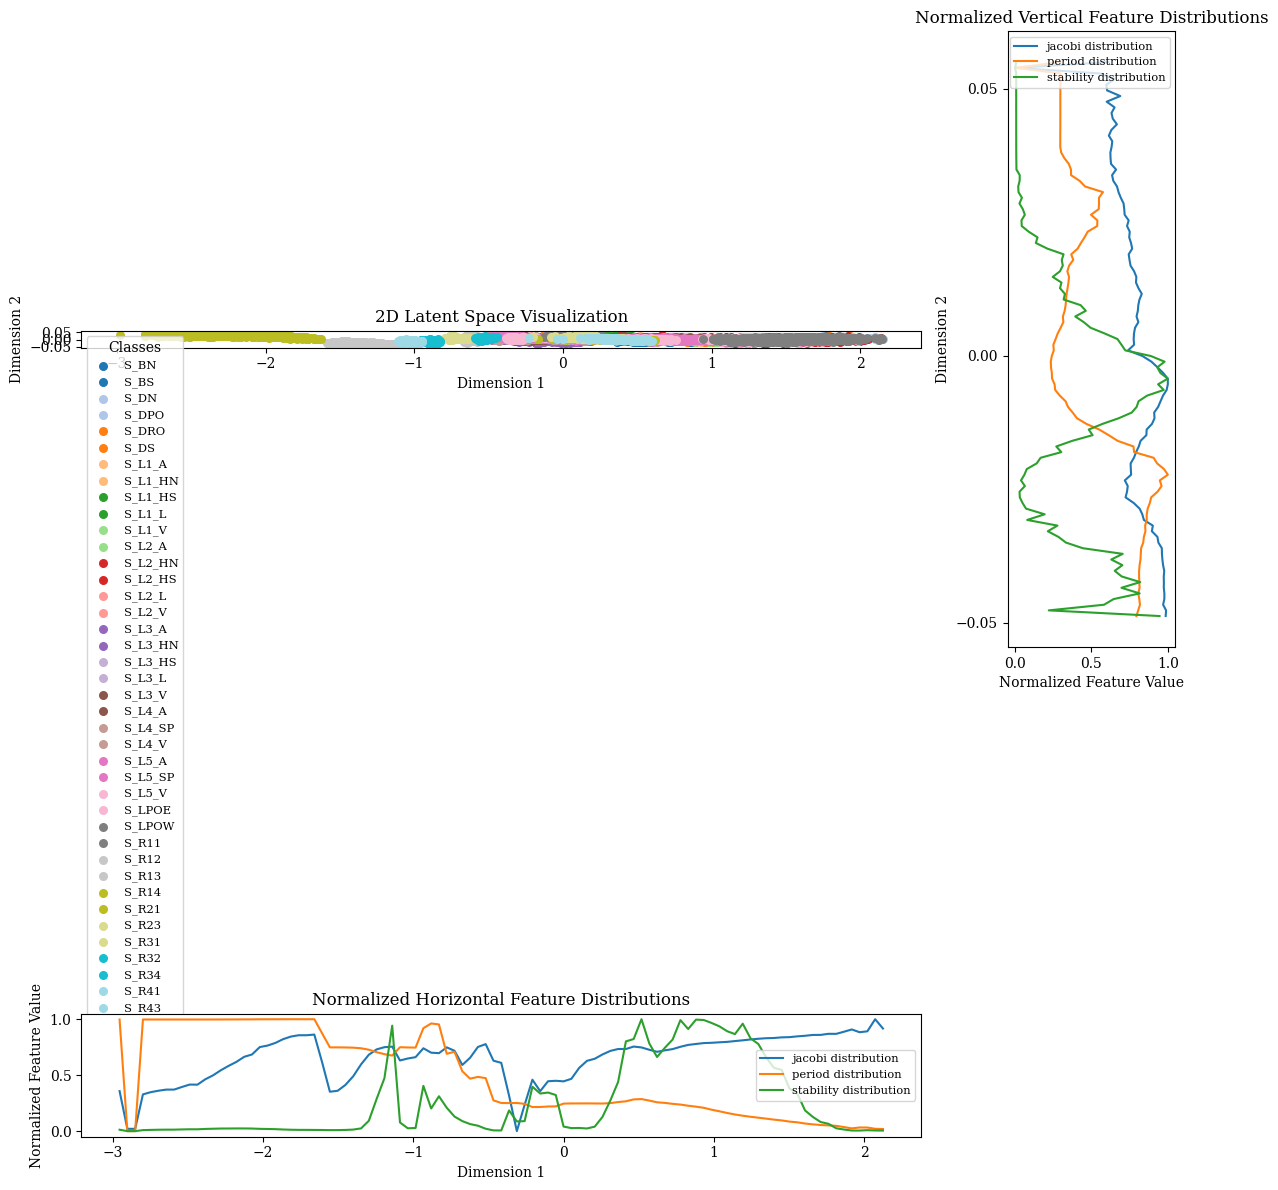

In [48]:
if want_to_generate_latent_space:
    if latent_mean.shape[1]==2:
        plot_latent_space_with_feature_distributions(latent_mean, np.array(family_labels), save_path=latent_space_path,
                                                    many_classes=False, features=features, feature_names=feature_names, show_legend=True, legend_fontsize=8.25)
    else:
        reduce_dimensions_plot_latent_space(latent_mean, np.array(family_labels),techniques=['PCA','UMAP','t-SNE'], save_path=latent_space_path +'_label',show_legend=False)


In [ ]:
klk

## Clustering

|||| change clases

In [ ]:
if want_to_get_cluster_metrics:
    cluster_metrics = evaluate_clustering_multiple_labels(latent_mean, classes, label_names=['label','type','subtype','direction'], clustering_method='gmm')
    add_experiment_metrics(experiments_folder, params=params, metrics=cluster_metrics)

# Convergence

In [ ]:
### make it converge and obtain refined_orbits

In [ ]:
# visualize_static_orbits(refined_data[:,:,1:], show_legend=False, save_path=converged_orbits_path)

In [ ]:
# export_dynamic_orbits_html(refined_data[:,:,1:], filename=dynamical_refined_orbits_path)

## Metrics

In [ ]:
generated_scaled_data = scaler.transform(refined_data)
generation_latent_mean, generation_latent_log_var = model.encode(generated_scaled_data)
generation_latent_representations = latent_mean.numpy()
generation_latent_representations.shape

CHANGE!!!

In [ ]:
if want_to_study_converged_orbits:
    non_matching_elements = find_non_matching_elements(latent_representation, generation_combined_latent_representation)
    convergence_metrics = {'percentage_convergence':len(generated_data)/100 ,'percentage_novelty':len(non_matching_elements)/len(generated_data)*100 , 'average_iterations_convergence':df['iterations_convergence'].mean()}
    add_experiment_metrics(experiments_folder, params=params, metrics=convergence_metrics)

## Latent Space

In [ ]:
if want_to_study_converged_orbits:
    if latent_mean.shape[1]==2:
        plot_combined_latent_space_2d(
            real_data=scaled_data, 
            synthetic_data=generated_scaled_data, 
            encoder=encoder, 
            synthetic_labels=list(range(0, len(generated_scaled_data))),
            annotation_mode='numbers',
            save_path=combined_latent_space_path,
            show_legend=True
        )
    else:
        reduce_dimensions_plot_combined_latent_space(
            real_data=scaled_data, 
            synthetic_data=generated_scaled_data, 
            encoder=encoder,
            techniques=['PCA','UMAP','t-SNE'],
            save_path=combined_latent_space_path
        )

## Check Novelty

Calculate Jacobi Constant on the dataset

In [ ]:
### array should be (45211, 300, 6)

In [ ]:
results = np.array([jacobi_constant(full_data[i][0], EM_MU)[0] for i in range(full_data.shape[0])])
orbit_df['calculated_jacobi'] = results

orbit_df.head()

Calculate Jacobi Constant and Period on the Refined Orbits

In [ ]:
new_jacobis = np.array([jacobi_constant(display_generation[i][0], EM_MU)[0] for i in range(display_generation.shape[0])])
synthetic_orbit_df['calculated_jacobi'] = new_jacobis
synthetic_orbit_df.rename(columns={'new_period': 'period'}, inplace=True)

synthetic_orbit_df.head()

Compare

In [ ]:
# Define the features to be used for distance calculation
features = ['period', 'calculated_jacobi']

# Calculate the distances
distances = calculate_closest_feature_distances(orbit_df, synthetic_orbit_df, features)

In [ ]:
distances